### **Contents:**

1. Summary on Models Comparison (AR-type vs. FBProphet)

  1.1. Theory

  1.2. Practive

2. Autoregressive model (AR-type:AR/ARMA/ARIMA)
3. FBprophet (Bayesian time series)

### **Summary-Comparison (AR-type vs. FBProphet):**

### Theory:

### 1. Data transformation:
- Autoregressive models demands stationary data and we need to spend a lot of time in diagnostics and exploration in order to identify and remove (differencing/Box-Cox transform)trend and seasonal effects (or heteroschedasticity) ;
- FBprophet model doesn't require stationary data ;

### 2. Model fitting:

- Multiple seasonalities (simultaneous yearly and weekly) and long-term seasonalities (365 days) is practically impossible to fit in AR-type (ARMA/ARIMA/SARIMA) models. We will not try SARIMA, so we can't capture yearly seasonality at all.

- Simple AR models will too quickly revert to mean;

- FBprophet model is created mostly for daily data and is a Bayesian modelling in essence.

### 3. Interpretability:

- In case of normality of residuals in AR-type models (AR,ARMA,ARIMA,SARIMA) we have higher interpretability as t-test statistics with coefficients provides us with statistical significance. For example, p in AR(p) of ARIMA defines number of lagged values used to predict current value, q in MA(q) - number of lagged errors, i in I(i) - number of differences etc. We can analyze confidence intervals for our predictions

- In case of FBprophet model is more complicated (see FBProphet paper), but we still have forecast intervals and fitted parameters, however interpretability is lower.

### Practice:


**Test set length:** 1 last year of observations (if not count additionally made cross-validation on train set)

**Results:**

In terms of RMSE max result for FBProphet beated ARIMA model.

- FBProphet: 8341.010
- ARIMA: 17753.85



## **Conclusion:**

With just few tweaks of model FBProphet beats ARIMA, which requires a lot of time for diagnostics.

In [0]:
#@title
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#@title
import os
os.chdir('drive/My Drive/test_task')
os.chdir('chow-test')
!pip install .
os.chdir('..')

### Imports

In [0]:
import numpy as np

import pandas as pd

import statsmodels.api as sm

from statsmodels.tsa.api import VAR

from statsmodels.tsa.stattools import adfuller,kpss

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

import statsmodels.tsa.api as smt

import matplotlib.pyplot as plt

import chow_test

## **1. Autoregressive model (AR-type)**


Plan:

- We will explore plot from the raw data;
- Detect any trend change, so that we can use it in our future AR-type model by incuding dummy variables;
- Deal with non-stationarity to the possible degree (long-term seasonality is hard to deal with), given that Adfuller and KPSS test won't probably see it;
- Decide on orders of models with the help of BIC (probably cross-validate)
- Fit model, make forecast and estimate MSE and MAPE.

#### Exploratory Data Analysis

Let's import our data and convert type of date column to 'datetime'.

In [0]:
df = pd.read_csv('test 2.csv',sep='|')
df.drop('Unnamed: 0',axis=1,inplace=True)

Plotting:

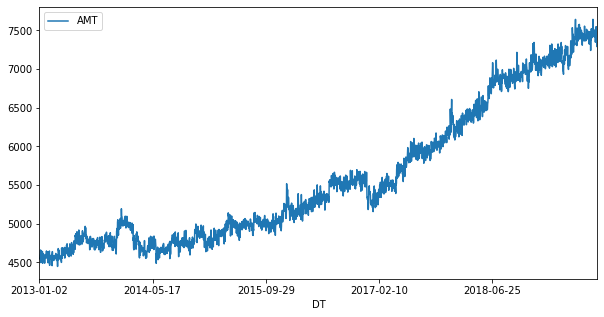

In [0]:
df.plot(x='DT',y='AMT',figsize=(10,5))
plt.show()

**Conclusion**:

We definitely have non-stationarity according to trend, but we will deal with that later.

It seems like data changed its trend at least THREE TIMES:

- at the start of 2014 year;
- just before the beginning of 2017 year;
- at the middle of 2018 year.

#### Trend Change detection for exogenous variables.

Let's show those possible candidates for trend change:

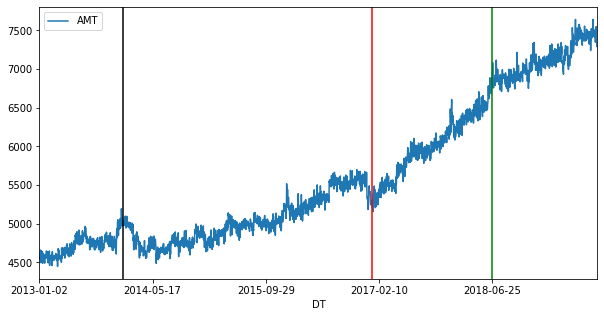

In [0]:
df.plot(x='DT',y='AMT',figsize=(10,5))
plt.axvline(x=370,c='black')
plt.axvline(x=1470,c='red')
plt.axvline(x=2000,c='green')
plt.show()

In [0]:
#fig,ax = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
#rolmean = df['AMT'].rolling(7).mean()
#plt.plot(rolmean, color='yellow', label='Rolling Mean')

We can choose in future either to include into our model additional dummy variable that signals trend changes from certain moment in time series or even cut those some past data. 

But let's perform Chow-test, that check for structural breaks in time series for specified points. 

In [0]:
#let's write wrap chow_test library functionality into function:
def df_chow_test(df,point_before,point_after):
  df['x'] = df.index
  df_before = df.loc[df['DT']<point_before]
  df_after = df.loc[df['DT']>point_after]
  x1 = df_before['x']
  y1 = df_before['AMT']
  x2 = df_after['x']
  y2 = df_after['AMT']
  f_value = chow_test.f_value(y1, x1, y2, x2)[0]
  p_value = chow_test.p_value(y1, x1, y2, x2)
  return f_value, p_value

Null hypothesis $H_0$ for such test is that there is no structural breaks in time series. So, let's find p-value, establishing significance level $alpha=0.05$:

#### Beginning of 2014:

In [0]:
f_value, p_value = df_chow_test(df,'2014','2013-12-31')
print('f_value for Chow-test:',f_value)
print(' ')
print('p_value:',float(p_value))

f_value for Chow-test: 909.7263398152887
 
p_value: 1.5377444222451716e-296


**Conclusion**:

We can reject $H_0$ of Chow-test that there is no trend change just at the beginning of 2014 year.

#### Before 2017:

In [0]:
f_value, p_value = df_chow_test(df,'2017','2016-12-31')
print('f_value for Chow-test:',f_value)
print(' ')
print('p_value:',p_value)

f_value for Chow-test: 4687.318052311513
 
p_value: 0.0


**Conclusion**:

We can reject $H_0$ of Chow-test that there is no trend change just before 2017 year.

#### Middle of 2018 (June 25):

In [0]:
f_value, p_value = df_chow_test(df,'2018-06-26','2018-06-25')
print('f_value for Chow-test:',f_value)
print(' ')
print('p_value:',p_value)

f_value for Chow-test: 1454.8871894365752
 
p_value: 0.0


**Conclusion**:

We can reject $H_0$ of Chow-test that there is no trend change just in the middle of 2018 year.

**Decision**:

After fitting more simple AR-model we will try to include changepoint as dummy variable. 

In FBProphet we will probably cut data before 2017th year as FBProphet is strongly prone to overfitting in case of such data.

### Non-stationarity (№ of lags/seasonality):

It's definitely that we have non-stationary data, given existence of trends and seasonality.

Let's additionally make autocorrelation (ACF) and partial correlation (PACF) plots anyway, to find number of lags, for which there is a correlation (PACF).

In ACF we can probably see some seasonality pattern, in PACF - correlation with prior lag after removing any indirect correlation of interven.observations.

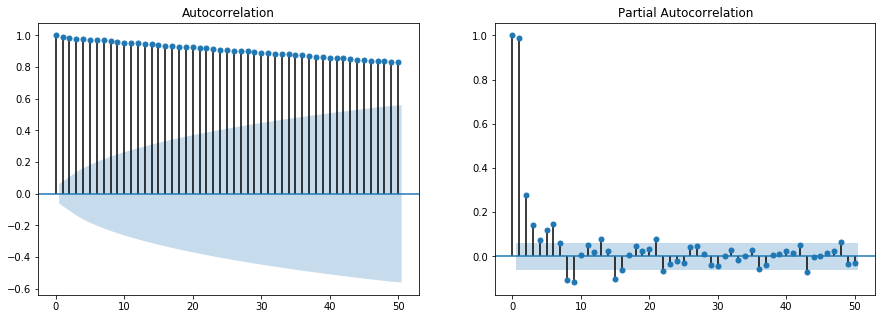

In [0]:
fig,ax = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
plot_acf(df['AMT'],ax=ax[0], lags=50, alpha=0.05)
plot_pacf(df['AMT'],ax=ax[1], lags=50, alpha=0.05)
plt.show()

**Conclusion:**

We see at ACF plot a clear presence of trend. So, data is stationary, we probably will need to do in future 1st order differencing.

We can additionally perform Augmented Dickey-Fuller (ADF) (optimal number of lags will be foiund with BIC criterion) and KPSS tests. ADF's null hypothesis $H_0$ is that time series data is non-stationary. On the contrary, KPSS's $H_0$ is that data is stationary. 

ADF test:

In [0]:
result = adfuller(df['AMT'],autolag='BIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.291215
p-value: 0.633182
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


**Conclusion**:

This test is not symmetrical.If we used any popular significance level such as $\alpha:0.01,0.05,0.1$, in any case we can't reject null hypothesis that time series data is non-stationary.

KPSS test:

In [0]:
statistic, p_value, n_lags, critical_values = kpss(df['AMT'])
print(f'KPSS Statistic: {statistic}')
print(f'p-value: {p_value}')
print(f'num lags: {n_lags}')
print('Critial Values:')
for key, value in critical_values.items():
  print(f'   {key} : {value}')

KPSS Statistic: 4.399251747878214
p-value: 0.01
num lags: 22
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value



**Conclusion:**

By KPSS we also see that data is non-stationary.

### Data transformation for AR model.

Let's perform 1st order differencing and perform ADF test again with plotting:

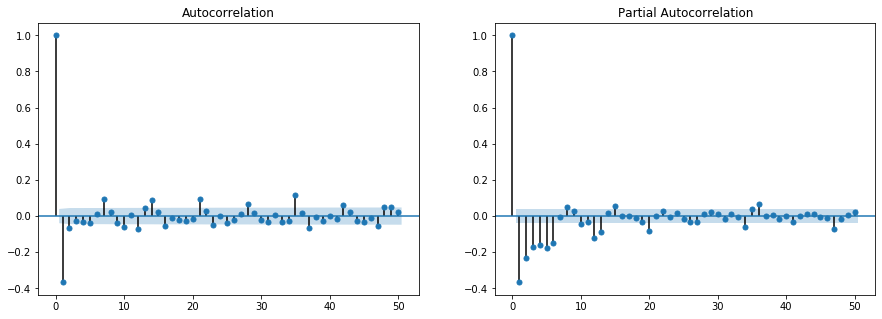

After 1st order differencing:

ADF Statistic: -20.235469
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [0]:
df['stationary']=df['AMT'].diff()
fig,ax = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
plot_acf(df['stationary'].drop(0),ax=ax[0], lags=50, alpha=0.05)
plot_pacf(df['stationary'].drop(0),ax=ax[1], lags=50, alpha=0.05)
plt.show()
print('After 1st order differencing:')
print('')
result = adfuller(df['stationary'].drop(0,axis=0),autolag='BIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

**Conclusion**

It seems from adfuller, that our data is stationary and that possible p in AR(p) model is 6 (from PACF)

We can see a slight seasonality in ACF, but it seems like it is not different much from white noise.


### Find optimal number of lags:

Let's check what is the optimal number of lags to be used in our Autoregression model with Bayesian Information Criterion, as it is known to highly penalize redundant lags. We will check first 10 lags, as bigger amount would be too long to train.

Our training set : all data but the last 365 days.

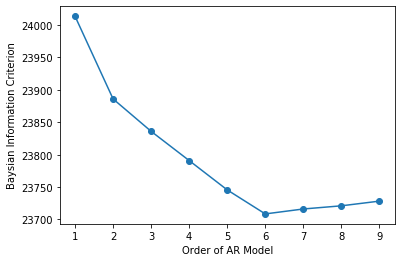

In [0]:
ts = df['stationary'].dropna()[:-367].values
dates = df['datetime'].dropna()[:-367].values

BIC = np.zeros(10)
for p in range(10):
    mod = smt.ARMA(ts, order=(p,0),dates=dates,freq='D')
    res = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = res.bic
    
# Plot the BIC as a function of p
plt.plot(range(1,10), BIC[1:10], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Baysian Information Criterion')
plt.show()

**Conclusion:**

We definitely can say that AR(6) (lag=6) is the most efficient model.

Let's try to fit the AR(6) model with 1st-order differencing via statsmodels:

In [0]:
ts = df['AMT'].dropna()[:-367].values
dates = df['datetime'].dropna()[:-367].values
model = smt.ARIMA(ts,(6,1,0),dates=dates,freq='D')
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 2098
Model:                 ARIMA(6, 1, 0)   Log Likelihood              -11823.694
Method:                       css-mle   S.D. of innovations             67.802
Date:                Mon, 30 Dec 2019   AIC                          23663.389
Time:                        14:36:36   BIC                          23708.579
Sample:                    01-03-2013   HQIC                         23679.941
                         - 10-01-2018                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1098      0.481      2.305      0.021       0.166       2.053
ar.L1.D.y     -0.5862      0.022    -27.139      0.000      -0.629      -0.544
ar.L2.D.y     -0.4532      0.025    -18.450      0.000      -0.501      -0.405
ar.L3.D.y     -0.3497      0.026    -13.636      0.000      -0.400      -0.299
ar.L4.D.y     -0.3035      0.026    -11.834      0.000      -0.354      -0.253
ar.L5.D.y     -0.2398      0.025     -9.760      0.000      -0.288      -0.192
ar.L6.D.y     -0.1453      0.022     -6.723      0.000      -0.188      -0.103
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8214           -0.9932j            1.2889           -0.1400
AR.2            0.8214           +0.9932j            1.2889            0.1400
AR.3           -0.3361           -1.3528j            1.3939           -0.2888
AR.4           -0.3361           +1.3528j            1.3939            0.2888
AR.5           -1.3104           -0.6443j            1.4602           -0.4273
AR.6           -1.3104           +0.6443j            1.4602            0.4273
-----------------------------------------------------------------------------
"""

It seems from p-values that exactly 6 coefficients are important for our model.

Let's look at our residuals to see whether they are normally distributed around zero-mean and have any correlation in order to tune order of MA.

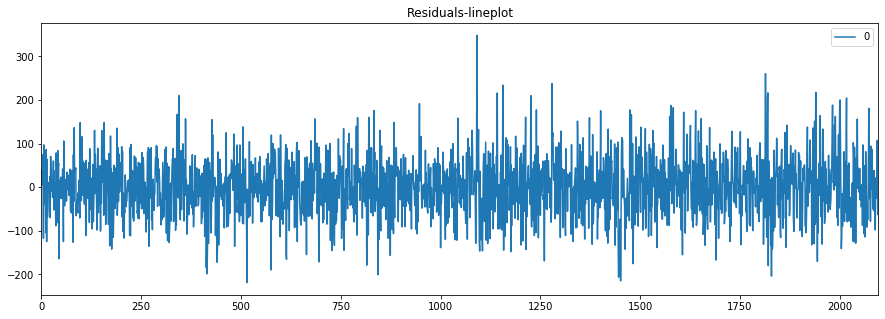

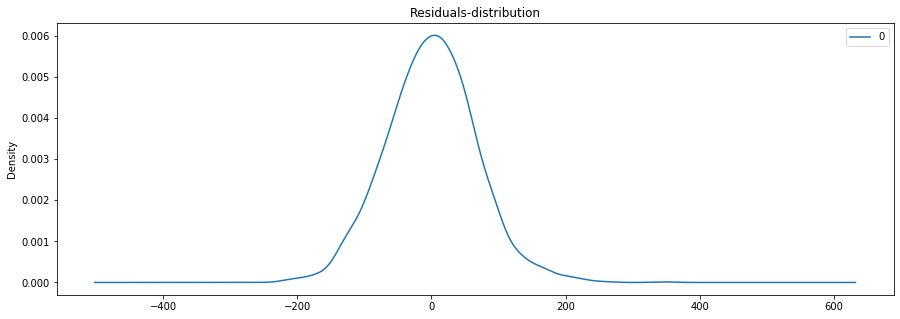

In [0]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(figsize=(15,5))
plt.title('Residuals-lineplot')
plt.show()
residuals.plot(kind='kde',figsize=(15,5))
plt.title('Residuals-distribution')
plt.show()

ACF and PACF:

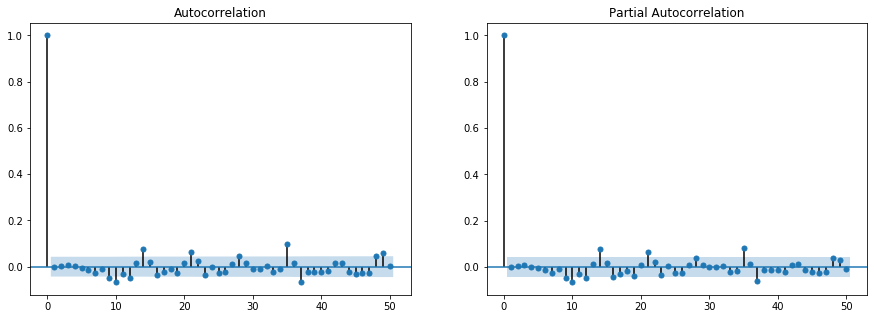

In [0]:
fig,ax = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
plot_acf(residuals.dropna(),ax=ax[0], lags=50, alpha=0.05)
plot_pacf(residuals.dropna(),ax=ax[1], lags=50, alpha=0.05)
plt.show()

**Conclusion:**

There is no obvious correlations in residuals and they are normally distributed (our coefficients are statistically significant).

Let's plot our prediction for one month/year of test data:

Month:

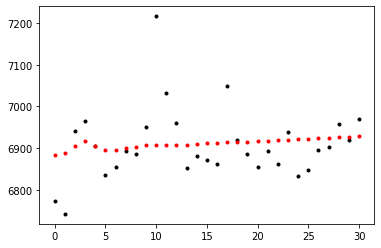

In [0]:
start_date = df['DT'].dropna()[-367:].iloc[0]
end_date = df['DT'].dropna()[-367:].iloc[30]
pred = model_fit.predict(start=start_date,end=end_date,typ='levels')
true = df['AMT'].dropna()[-367:].values[:31]
ind_pred=[i for i in range(len(pred))]
ind_true=[i for i in range(len(true))]
plt.plot(ind_true, true, c='black', marker='o', ms=3, linestyle='None', label='True')
plt.plot(ind_pred, pred, c='r', marker='o', ms=3, linestyle='None', label='True')
plt.show()

1 year:

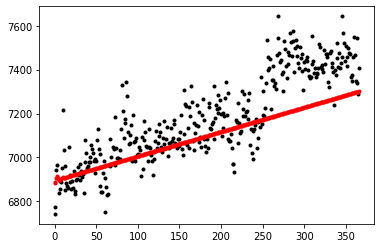

In [0]:
start_date = df['DT'].dropna()[-367:].iloc[0]
end_date = df['DT'].dropna()[-367:].iloc[-1]
pred = model_fit.predict(start=start_date,end=end_date,typ='levels')
true = df['AMT'].dropna()[-367:].values
ind_pred=[i for i in range(len(pred))]
ind_true=[i for i in range(len(true))]
plt.plot(ind_true, true, c='black', marker='o', ms=3, linestyle='None')
plt.plot(ind_pred, pred, c='r', marker='o', ms=3, linestyle='None')
plt.show()

It seems like our model didn't get trend well and seasonality, if such is present.

Let's try various orders of MA in time series cross-validation (specific type of cross validation):

In [0]:
splits = TimeSeriesSplit(n_splits=10)

q_values = [0,1,2,3]

res_results=pd.DataFrame()
p_par=[]
q_par=[]
mean_res=[]
for q in q_values:
  p_par.append(p)
  q_par.append(q)
  res=[]
  for train_index, test_index in splits.split(ts):
      train = ts[train_index]
      test = ts[test_index]
      model = smt.ARIMA(train,(6,1,q))
      model_fit=model.fit()
      start_date = test_index[0]
      end_date = test_index[-1]
      pred = model_fit.predict(start=start_date,end=end_date)
      res.append(mean_squared_error(test,pred))
  mean_res.append(np.mean(res))
     

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



In [0]:
mean_res

[29405342.13561783, 29405365.079472393, 29406757.21291842, 29405890.751709513]

Seems like there are not much difference between various orders of MA in terms of MSE. Let's try adding exogeneous variable.

### Add exogenous

We will include exogenous variable that will signal presence of trend.

In [0]:
df['trend_change'] = 0
df.loc[df['DT']>'2013-12-31','trend_change'] = 1
df.loc[df['DT']>'2016-12-31','trend_change'] = 2
df.loc[df['DT']>'2018-06-25','trend_change'] = 3

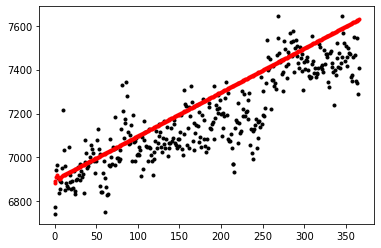

In [0]:
ts = df['AMT'].dropna()[:-367].values
dates = df['datetime'].dropna()[:-367].values
exog1 = df['trend_change'].dropna()[:-367].values
model = smt.ARIMA(ts,(6,1,0),dates=dates,freq='D',exog = exog1)
model_fit=model.fit()

start_date = df['DT'].dropna()[-367:].iloc[0]
end_date = df['DT'].dropna()[-367:].iloc[-1]
exog_pred=df['trend_change'].dropna()[-367:].values

pred = model_fit.predict(start=start_date,end=end_date,exog = exog_pred,typ='levels')
true = df['AMT'].dropna()[-367:].values
ind_pred=[i for i in range(len(pred))]
ind_true=[i for i in range(len(true))]
plt.plot(ind_true, true, c='black', marker='o', ms=3, linestyle='None')
plt.plot(ind_pred, pred, c='r', marker='o', ms=3, linestyle='None')
plt.show()

Let's check mean squared error:

In [0]:
mean_squared_error(true,pred)

17753.853915181575

### GREAT!

**Conclusion**

Seems like we have improved our model in terms of finding trend greatly just by including exogeneous variable.

### What can be improved:

- We can use in future SARIMA to better model one type of seasonality, however it's dubious that it will work on daily data, as it goes from viewpoint of time series expert Rob Hyndman.
- We can try TBATS etc.

## **2. FBprophet**

In [0]:
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

We will use only data from 2017, so that we won't overfit on data with another trend.

Testing data would be the same - from 2019 year.

In [0]:
train = df[df.datetime < '2019']
train = train[train.datetime > '2016-12-31']
test = df[df.datetime > '2018-12-31']
train.rename(columns={'datetime':'ds','AMT':'y'},inplace=True)
test.rename(columns={'datetime':'ds','AMT':'y'},inplace=True)

We will assume that we have yearly seasonality. Authors of FBProphet recommended Fourier order of 10 for yearly data in their paper. We can try it:

In [0]:
model = Prophet(interval_width=0.95) 
model.add_seasonality(
                name='yearly', 
                period=365.25,
                fourier_order=10,
                )
model.fit(train);

In [0]:
# Predict on test set with model
test_fcst = model.predict(df=test)

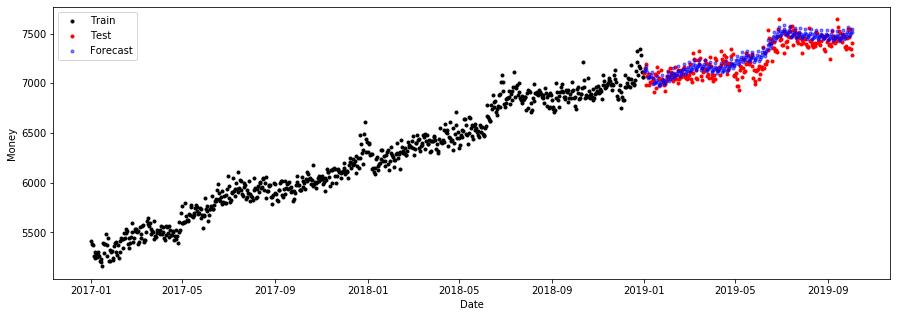

In [0]:
#look at visuals 
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train['ds'], train['y'], c='black', marker='o', ms=3, linestyle='None', label='Train')
ax.plot(test['ds'], test['y'], c='r', marker='o', ms=3, linestyle='None', label='Test')
ax.plot(test_fcst['ds'], test_fcst['yhat'], c='b', marker='o', ms=3, linestyle='None', label='Forecast', alpha=0.5)
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Money');

In [0]:
mean_squared_error(test['y'],test_fcst['yhat'])

8341.010578147694

Seems like we have nailed out time series from the first try. Let's plot where FBProphet automatically detected changepoints:

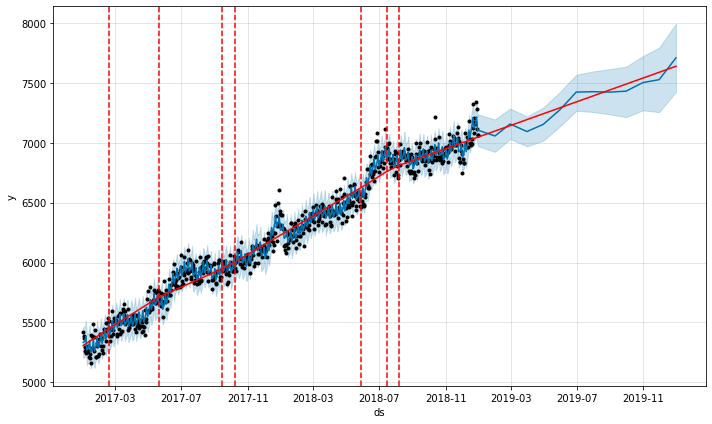

In [0]:
#generate forecast
future_data = model.make_future_dataframe(periods=12, freq = 'm')
forecast = model.predict(future_data)
fig = model.plot(forecast)
from fbprophet.plot import add_changepoints_to_plot
a = add_changepoints_to_plot(fig.gca(), model, forecast)

plt.show()

Seems like FBProphet rightly figured out all changepoints.

Let's see trend and seasonal components

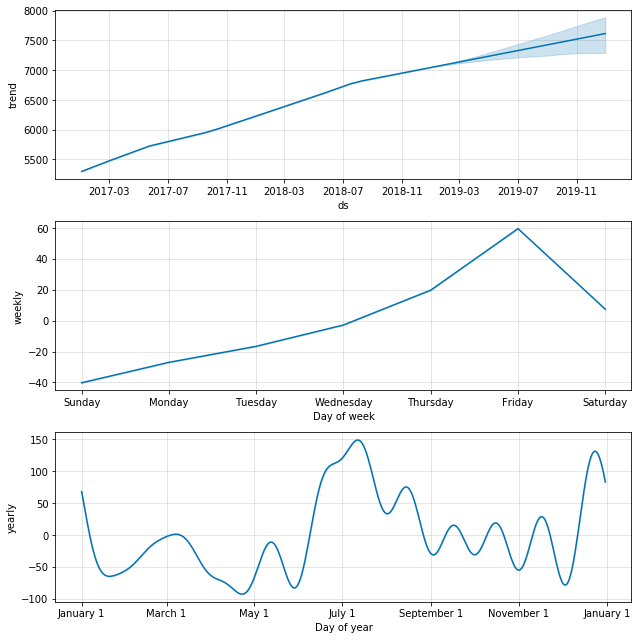

In [0]:
fig = model.plot_components(forecast)

We see that weekly maximum increase in 'AMT' was observed on Fridays, yearly - in July-August-December-January'. 

Let's try some cross-validation on our model. Citation from 'Diagnostics' page of FBProphet:

"We specify the forecast horizon (horizon), and then optionally the size of the initial training period (initial) and the spacing between cutoff dates (period). By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon."

INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-06-04 00:00:00 and 2018-11-01 00:00:00


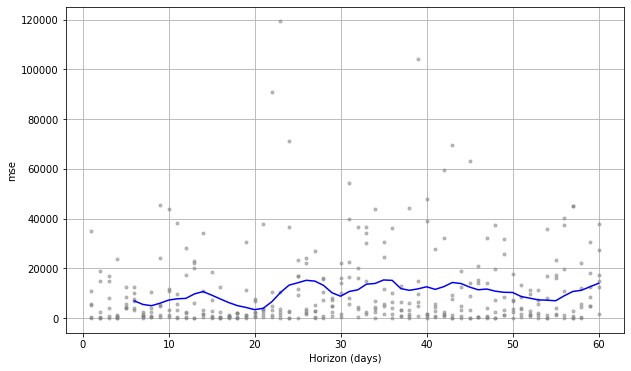

In [0]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
#We will perform 60-days forecast for every 30 days with initial training set of 500 days
df_cv = cross_validation(model, initial='500 days', period='30 days', horizon = '60 days')
df_p = performance_metrics(df_cv)

fig = plot_cross_validation_metric(df_cv, metric='mse')

### What could be done more

We could perform some grid-search for more optimal parameters like:

- Fourier order
- Fourier priors
- length of training set
- Changepoint priors
- Manually defined changepoints etc.